In [16]:
!pip install pandas numpy scikit-learn matplotlib seaborn joblib
!pip install evidently==0.3.3


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Train size: 8000, Test size: 2000
Default rate: 27.67%
Training Performance:


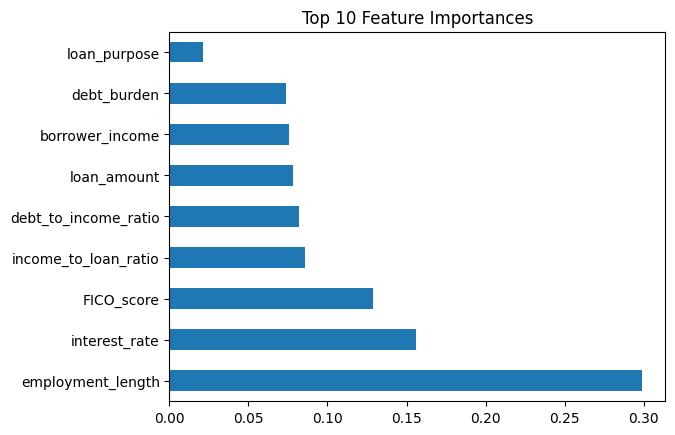

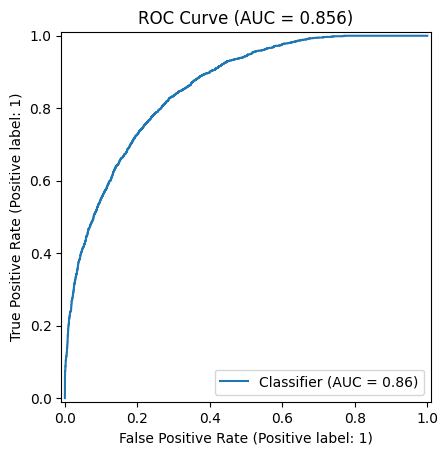


Test Performance:


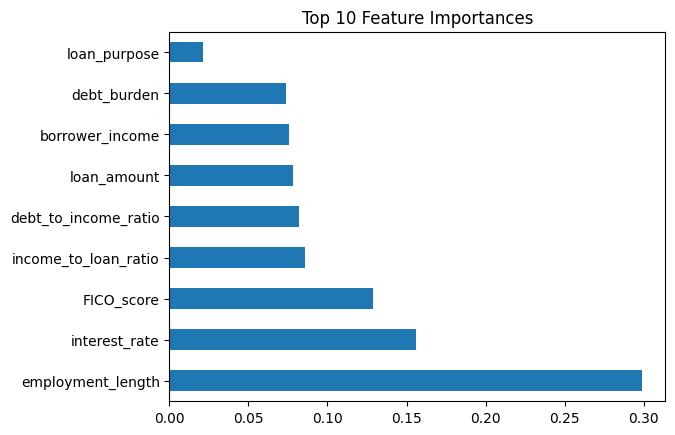

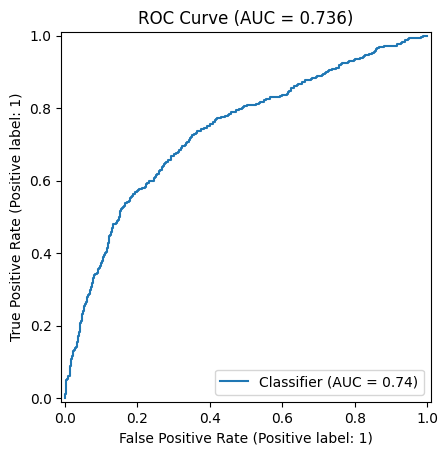

Evidently report output:
{'metrics': [{'metric': 'ClassificationQualityMetric', 'result': {'current': {'accuracy': 0.7295, 'precision': 0.5095238095238095, 'recall': 0.5804701627486437, 'f1': 0.5426880811496196, 'roc_auc': None, 'log_loss': None, 'tpr': 0.5804701627486437, 'tnr': 0.7864547339322737, 'fpr': 0.21354526606772634, 'fnr': 0.41952983725135623}, 'reference': {'accuracy': 0.786, 'precision': 0.5966872110939908, 'recall': 0.6996386630532972, 'f1': 0.644074844074844, 'roc_auc': None, 'log_loss': None, 'tpr': 0.6996386630532972, 'tnr': 0.8190459730383685, 'fpr': 0.18095402696163151, 'fnr': 0.3003613369467028}, 'target_name': 'loan_default'}}, {'metric': 'ClassificationClassBalance', 'result': {}}, {'metric': 'ClassificationConfusionMatrix', 'result': {'current_matrix': {'labels': [0, 1], 'values': [[1138, 309], [232, 321]]}, 'reference_matrix': {'labels': [0, 1], 'values': [[4739, 1047], [665, 1549]]}, 'target_names': None}}, {'metric': 'ClassificationQualityByClass', 'result': {

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from evidently.report import Report
from evidently.metric_preset import ClassificationPreset
from evidently import ColumnMapping
import evidently

def generate_loan_data(num_records=5000):
    np.random.seed(42)
    data = pd.DataFrame({
        'loan_amount': np.random.lognormal(8, 0.4, num_records).astype(int),
        'interest_rate': np.random.uniform(3, 25, num_records),
        'borrower_income': np.random.lognormal(10, 0.3, num_records).astype(int),
        'debt_to_income_ratio': np.random.uniform(0.1, 0.8, num_records),
        'FICO_score': np.random.randint(300, 850, num_records),
        'employment_length': np.random.choice(['<1y', '1-3y', '3-5y', '5-10y', '10+y'], num_records),
        'loan_purpose': np.random.choice(['debt_consolidation', 'home_improvement', 
                                        'business', 'medical', 'other'], num_records),
    })

    income_ratio = data['borrower_income'] / data['loan_amount']
    risk_factors = (
        0.3 * (data['interest_rate'] / 25) +
        0.4 * (1 - (data['FICO_score'] / 850)) +
        0.2 * data['debt_to_income_ratio'] +
        0.1 * (1 - np.log(income_ratio + 1))
    )

    employment_risk = {
        '<1y': 0.4, '1-3y': 0.2, '3-5y': 0.1, '5-10y': 0.05, '10+y': 0.01
    }
    risk_factors += data['employment_length'].map(employment_risk)

    default_prob = 1 / (1 + np.exp(-5 * (risk_factors - 0.65)))
    data['loan_default'] = np.random.binomial(1, default_prob)
    data['application_id'] = [f'APP{i:05d}' for i in range(num_records)]
    
    return data

def engineer_features(df):
    df['income_to_loan_ratio'] = df['borrower_income'] / df['loan_amount']
    df['debt_burden'] = df['debt_to_income_ratio'] * df['borrower_income']

    emp_map = {'<1y': 0, '1-3y': 1, '3-5y': 2, '5-10y': 3, '10+y': 4}
    purpose_map = {p: i for i, p in enumerate(df['loan_purpose'].unique())}
    
    df['employment_length'] = df['employment_length'].map(emp_map)
    df['loan_purpose'] = df['loan_purpose'].map(purpose_map)
    
    return df

def evaluate_model(model, X, y, threshold=0.5):
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    auc = roc_auc_score(y, y_proba)
    report = classification_report(y, y_pred, output_dict=True)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title('Top 10 Feature Importances')
    plt.show()

    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_predictions(y, y_proba)
    plt.title(f'ROC Curve (AUC = {auc:.3f})')
    plt.show()
    
    return {
        'auc': auc,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
        'classification_report': report
    }

def add_predictions(df, model):
    cols_to_drop = ['loan_default']
    if 'application_id' in df.columns:
        cols_to_drop.append('application_id')
    X = df.drop(cols_to_drop, axis=1)
    df['prediction_probas'] = model.predict_proba(X)[:, 1]
    df['prediction'] = model.predict(X)
    return df

def validate_model(reference_data, current_data, model, thresholds):
    def add_predictions(df, model):
        X = df.drop(['loan_default', 'application_id'], axis=1, errors='ignore')
        df['prediction_probas'] = model.predict_proba(X)[:, 1]
        df['prediction'] = model.predict(X)
        return df

    reference_data_with_preds = add_predictions(reference_data.copy(), model)
    current_data_with_preds = add_predictions(current_data.copy(), model)

    column_mapping = ColumnMapping(
        target='loan_default',
        prediction='prediction'
    )

    report = Report(metrics=[ClassificationPreset()])
    report.run(
        reference_data=reference_data_with_preds,
        current_data=current_data_with_preds,
        column_mapping=column_mapping
    )

    results = report.as_dict()
    print("Evidently report output:")
    print(results)

    metrics_list = results.get('metrics') or results.get('metric_results')
    if not metrics_list:
        raise ValueError("Metrics not found in Evidently report output")

    first_metric = metrics_list[0]
    if 'result' in first_metric and 'metrics' in first_metric['result']:
        classification_metrics = first_metric['result']['metrics']
    else:
        classification_metrics = first_metric.get('metrics', {})

    print("\nExtracted classification metrics:")
    print(classification_metrics)

    auc = classification_metrics.get('roc_auc') or classification_metrics.get('auc')
    precision = classification_metrics.get('precision')

    print("\nValidation Results:")
    validation_passed = True

    if auc is None or auc < thresholds['auc']:
        print(f"AUC validation failed: {auc} < {thresholds['auc']}")
        validation_passed = False
    else:
        print(f"AUC validation passed: {auc} >= {thresholds['auc']}")

    if precision is None or precision < thresholds['precision']:
        print(f"Precision validation failed: {precision} < {thresholds['precision']}")
        validation_passed = False
    else:
        print(f"Precision validation passed: {precision} >= {thresholds['precision']}")

    return validation_passed

loan_data = generate_loan_data(10000)
processed_data = engineer_features(loan_data.copy())

X = processed_data.drop(['loan_default', 'application_id'], axis=1)
y = processed_data['loan_default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
print(f"Default rate: {y.mean():.2%}")

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)

print("Training Performance:")
train_metrics = evaluate_model(model, X_train, y_train)

print("\nTest Performance:")
test_metrics = evaluate_model(model, X_test, y_test)

thresholds = {
    'auc': 0.80,
    'precision': 0.75
}

validation_result = validate_model(
    reference_data=pd.concat([X_train, y_train], axis=1),
    current_data=pd.concat([X_test, y_test], axis=1),
    model=model,
    thresholds=thresholds
)

if validation_result:
    print("Model validation passed! Saving artifacts...")

    joblib.dump(model, 'loan_default_model.pkl')
    X_test[:100].to_parquet('test_sample.parquet')

    pd.DataFrame(X_train.dtypes, columns=['dtype']).to_csv('data_schema.csv')
    
    print("Artifacts saved:")
    print("- loan_default_model.pkl (model)")
    print("- test_sample.parquet (test data sample)")
    print("- data_schema.csv (data schema)")
else:
    print("Model validation failed! Not saving artifacts.")


print("\nSimulating data drift...")
drift_data = generate_loan_data(1000)

drift_data['interest_rate'] = drift_data['interest_rate'] * 1.3
drift_data['FICO_score'] = drift_data['FICO_score'] * 0.95
drift_data = engineer_features(drift_data)

y_drift_proba = model.predict_proba(drift_data.drop(['loan_default', 'application_id'], axis=1))[:, 1]
drift_auc = roc_auc_score(drift_data['loan_default'], y_drift_proba)

print(f"Performance on drifted data: AUC = {drift_auc:.3f} (Original: {test_metrics['auc']:.3f})")
print(f"Performance drop: {(test_metrics['auc'] - drift_auc):.3f}")

def predict_default(application_data):
    """Predict loan default probability for a single application"""
    app_df = pd.DataFrame([application_data])
    processed = engineer_features(app_df)
    proba = model.predict_proba(processed.drop(['loan_default', 'application_id'], axis=1, errors='ignore'))[0][1]
    return proba

sample_application = {
    'application_id': 'TEST001',
    'loan_amount': 25000,
    'interest_rate': 15.5,
    'borrower_income': 75000,
    'debt_to_income_ratio': 0.35,
    'FICO_score': 680,
    'employment_length': '3-5y',
    'loan_purpose': 'debt_consolidation'
}

default_prob = predict_default(sample_application)
print(f"\nPrediction for sample application:")
print(f"Default probability: {default_prob:.1%}")
print(f"Recommendation: {'APPROVE' if default_prob < 0.5 else 'REJECT'}")